In [1]:
import numpy as np
from sklearn.cluster import KMeans
import cv2
np.seterr(divide='ignore', invalid='ignore')
from collections import namedtuple

def cmask(index,radius,array):
  	
  a,b = index
  is_rgb = len(array.shape)

  if is_rgb == 3:
     ash = array.shape
     nx=ash[0]
     ny=ash[1]

  else:
     nx,ny = array.shape
  
  s = (nx,ny)
  image_mask = np.zeros(s)
  y,x = np.ogrid[-a:nx-a,-b:ny-b]
  mask = x*x + y*y <= radius*radius
  image_mask[mask] = 1
  return(image_mask)




def colorc15mask(input_image,mask_image):
	# All matrices are normalized from 0 to 1
	
	[rows,cols]=mask_image.shape
	
	# Input image is a numpy 3D array
	ColorChannel = namedtuple("ColorChannel", "c1 c2 c3 c4 c5 c6 c7 c8 c9 c10 c11 c12 c13 c14 c15 c16")
	
	red = input_image[:,:,2]
	green = input_image[:,:,1]
	blue = input_image[:,:,0]
	
	red = red.astype(float)
	green = green.astype(float)
	blue = blue.astype(float)
	
	# RGB images for transfer
	red_image = np.multiply(red,mask_image)
	green_image = np.multiply(green,mask_image)
	blue_image = np.multiply(blue,mask_image)
	
	
	
	im_mask = mask_image.flatten()
	find_loc = np.where(im_mask==1)
	find_loc = list(find_loc)
	
	red = red.flatten()
	blue = blue.flatten()
	green = green.flatten()

	red_select = red[tuple(list(find_loc))]
	green_select = green[tuple(list(find_loc))]
	blue_select = blue[tuple(list(find_loc))]
	
	
	

	# BR image
	br_num = blue_select - red_select
	br_den = blue_select + red_select
	BR = br_num/br_den
	BR[np.isnan(BR)] = 0  # Replacing all NANs with 0
	BR = showasImage(BR)  # Scale it to 0 to 255.


	# Final image (with proper mask) for transfer
	index = 0
	BR_image = np.zeros([rows,cols])
	
	
	for i in range(0,rows):
		for j in range(0,cols):

			if mask_image[i,j]==1:
				
				BR_image[i,j] = BR[index]
				
				index = index + 1
			
	

	return(BR_image)



def make_cluster_mask_default(input_matrix,mask_image):
	
	[rows,cols]=mask_image.shape
	
	im_mask_flt = mask_image.flatten()
	find_loc = np.where(im_mask_flt==1)
	find_loc = list(find_loc)
	
	input_vector = input_matrix.flatten()
	
	input_select = input_vector[tuple(list(find_loc))]
	
	
	X = input_select.reshape(-1, 1)
	k_means = KMeans(init='k-means++', n_clusters=2)
	k_means.fit(X)
	k_means_labels = k_means.labels_
	k_means_cluster_centers = k_means.cluster_centers_
	k_means_labels_unique = np.unique(k_means_labels)
	


	
	# This is checked only for c15
	center1 = k_means_cluster_centers[0]
	center2 = k_means_cluster_centers[1]
	
	
	if center1 < center2:
		# Interchange the levels.
		k_means_labels[k_means_labels == 0] = 99
		k_means_labels[k_means_labels == 1] = 0
		k_means_labels[k_means_labels == 99] = 1
		
	
		
	
	# 0 is sky and 1 is cloud
	cloud_pixels = np.count_nonzero(k_means_labels == 1)
	sky_pixels = np.count_nonzero(k_means_labels == 0)
	total_pixels = cloud_pixels + sky_pixels
	
	#print (cloud_pixels,total_pixels)
	print ('Out of a total of ', str(total_pixels), ' pixels, there are ', str(cloud_pixels), ' cloud pixels.')
	cloud_coverage = float(cloud_pixels)/float(total_pixels)
	
	# Final threshold image for transfer
	index = 0
	Th_image = np.zeros([rows,cols])
	for i in range(0,rows):
		for j in range(0,cols):
			
			if mask_image[i,j]==1:
				#print (i,j)
				#print (index)
				Th_image[i,j] = k_means_labels[index]
				index = index + 1
			
	

	return(Th_image,cloud_coverage)	


def showasImage(input_matrix):
	
	is_matrix = len(input_matrix.shape)
	
	if is_matrix == 2: # Input is a 2D numpy array
		
		
		(rows,cols) = input_matrix.shape
		
		output_matrix = np.zeros([rows,cols])
		
		inp_flat = input_matrix.flatten()
		
		min_value = np.amin(inp_flat)
		max_value = np.amax(inp_flat)
		
		diff = max_value - min_value
		
		for i in range(0,rows):
			for j in range(0,cols):
				output_matrix[i,j] = ((input_matrix[i,j] - min_value)/diff)*255
				
	else:	# Input is a 1D numpy array
		(rows) = input_matrix.size
		output_matrix = np.zeros(rows)
		
		inp_flat = input_matrix
		
		min_value = np.amin(inp_flat)
		max_value = np.amax(inp_flat)
		
		diff = max_value - min_value
		
		for i in range(0,rows):
			output_matrix[i] = ((input_matrix[i] - min_value)/diff)*255

	
	return(output_matrix)

def cloudSegment(image_loc):
	

	print ('Processing ',image_loc)


	im = cv2.imread(image_loc) 

	index = [1728, 2592]  # Center of the image
	im_mask = cmask(index,1000,im) # Mask with radius 1000 pixels


	lx, ly, _ = im.shape


	if lx>ly:
		print ('Rotating')
		im = ndimage.rotate(im, -90)

	(inp_mat) = colorc15mask(im,im_mask)
	(th_image,coverage) = make_cluster_mask_default(inp_mat,im_mask)


	return(th_image,coverage)

Processing  ../2015-04-21-13-30-00.jpg
Out of a total of  3141549  pixels, there are  1665119  cloud pixels.
Coverage is  0.5300312043517386


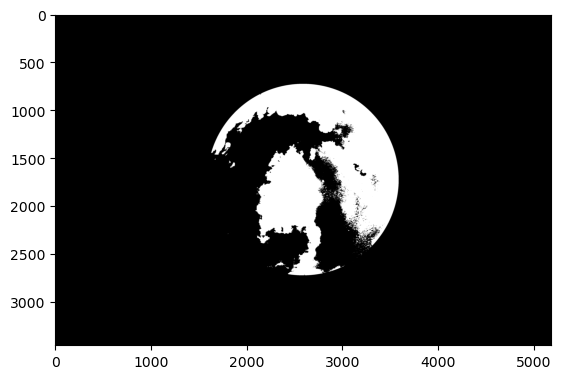

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc


# Mention your sky/cloud image path here. Please make sure that your input image is inside "image" folder.
image_loc = '../2015-04-21-13-30-00.jpg'


# This is the main component that performs the cloud coverage computation. It may take around 40s to run this component
(th_image,coverage) = cloudSegment(image_loc)


# Saving your final result. This is saved inside the "image" folder. The resultant image is appended with the suffix "-result" on the original file name
my_string = image_loc.split('.')
threshold_img_name = '.' + my_string[-2] + '-result.png'
plt.imshow(th_image,cmap='gray')

# print ('Binary image is saved')

print ('Coverage is ',coverage)

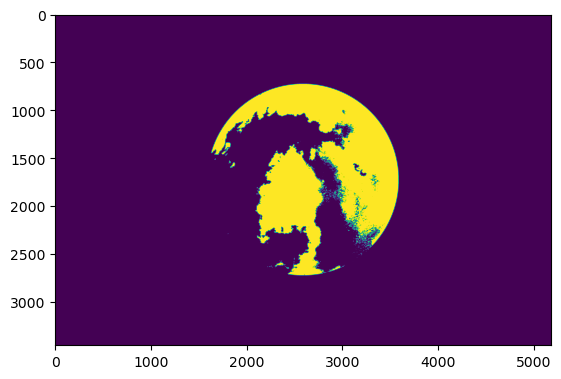

In [4]:
plt.imshow(th_image)

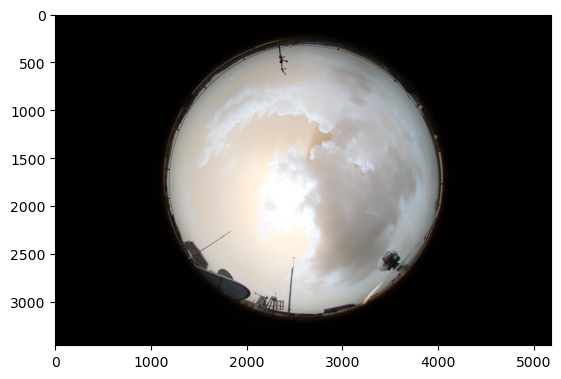

In [3]:
import cv2
image = cv2.imread(image_loc)
plt.imshow(image)